In [97]:
from IPython.display import display, clear_output

In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
clear_output()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [99]:
#imports 
import os
import torch 
import torch.nn as nn 
import torchvision 
from torchvision.io import read_image
from torch.utils.data import DataLoader , Dataset , random_split , Subset
from torchvision.datasets import ImageFolder
import torch.optim as optim 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
import random
import torch.nn.functional as F

In [100]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform:

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [101]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    GrayScaleToColorTransform()
])

images_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/101-objectcategories', transform=transform)

In [102]:
(gray , color) , _ = images_dataset[0]

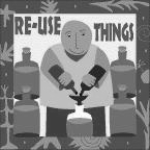

In [103]:
transforms.functional.to_pil_image(gray)

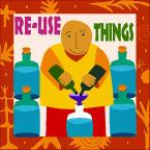

In [104]:
transforms.functional.to_pil_image(color)


In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'you are using: {device}')

you are using: cuda


In [106]:
# Split the dataset into training and test sets
train_size = int(0.8 * len(images_dataset))
test_size = len(images_dataset) - train_size
train_dataset, test_dataset = random_split(images_dataset, [train_size, test_size])

# Create DataLoader with the loaded datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [107]:
def show_images(gray , color):
    fig, ax = plt.subplots(5, 2, figsize=(15, 15))
    ax[0, 0].set_title('GrayScale')
    ax[0, 1].set_title('Colored')
    for i in range(5):
        ax[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        ax[i, 0].axis('off')
        
        ax[i, 1].imshow(color[i].permute(1, 2, 0))
        ax[i, 1].axis('off')
    plt.show()

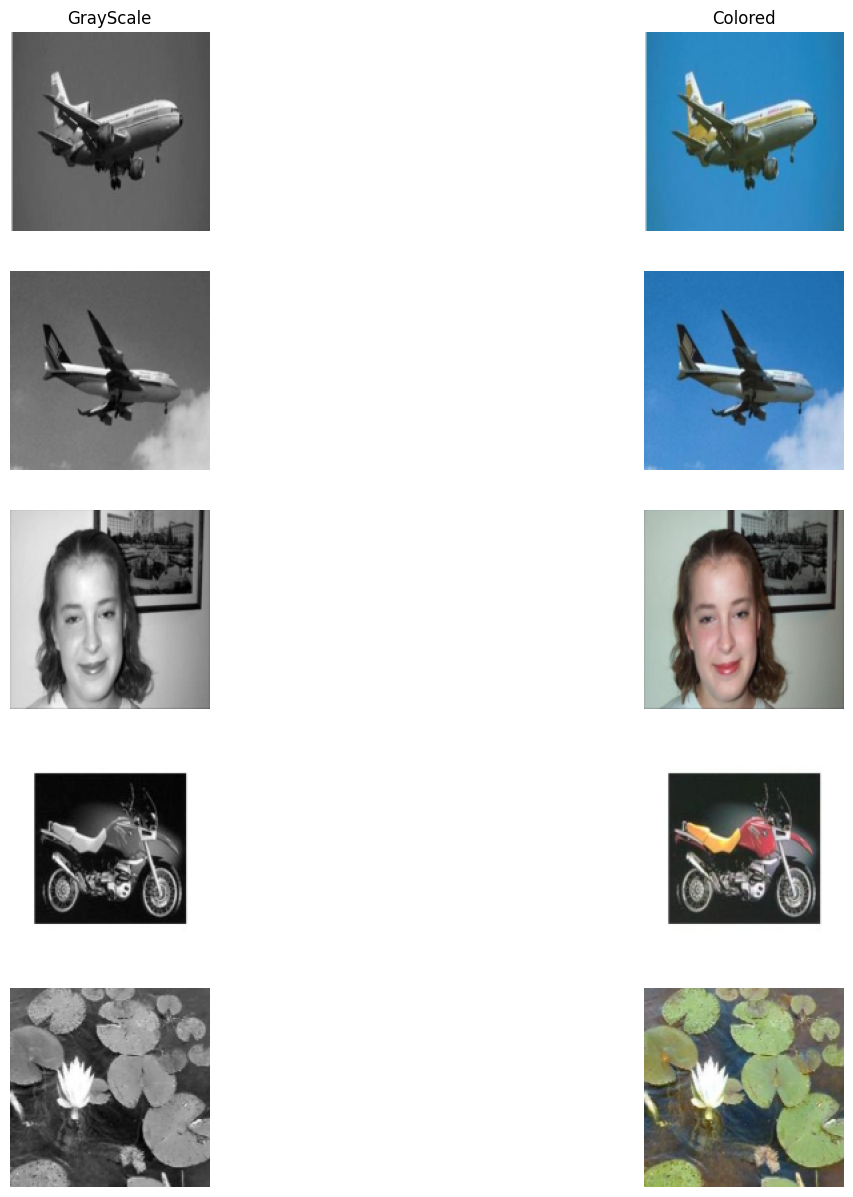

In [108]:
(gray, color) , _ = next(iter(train_loader))
show_images(gray , color)

In [109]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample(Encoder)
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample(Decoder)
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

In [110]:
# Initialize the model
model = ColorAutoEncoder().to(device)

In [111]:
# Initialize the Hyperparameters
epochs = 10 
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = learning_rate)

In [112]:
for epoch in range(epochs):
    running_loss = 0.0
    for (gray,color),_ in (train_loader):
        gray = gray.to(device)
        color = color.to(device)
        
        # make model prediction 
        pred = model(gray)
        
        optimizer.zero_grad()
        
        # calculate loss between colored image and pred 
        loss = criterion(color , pred)
        
        # calculate gradients and backpropagate 
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        
    print(f'Epoch: {epoch+1} , loss {running_loss:.6f}')

Epoch: 1 , loss 2.542648
Epoch: 2 , loss 1.291614
Epoch: 3 , loss 1.205721
Epoch: 4 , loss 1.167720
Epoch: 5 , loss 1.156423
Epoch: 6 , loss 1.136345
Epoch: 7 , loss 1.131802
Epoch: 8 , loss 1.110649
Epoch: 9 , loss 1.093302
Epoch: 10 , loss 1.081340


In [113]:
# test on testing data 
total_loss = 0.0
with torch.no_grad():
    for (gray,color) , _ in (test_loader):
        gray = gray.to(device)
        color = color.to(device)
        
        pred = model(gray)
        
        loss = criterion(color , pred)
        total_loss+=loss.item()
        
    print(f'total testing loss is : {total_loss/len(test_loader):.3f}')

total testing loss is : 0.009


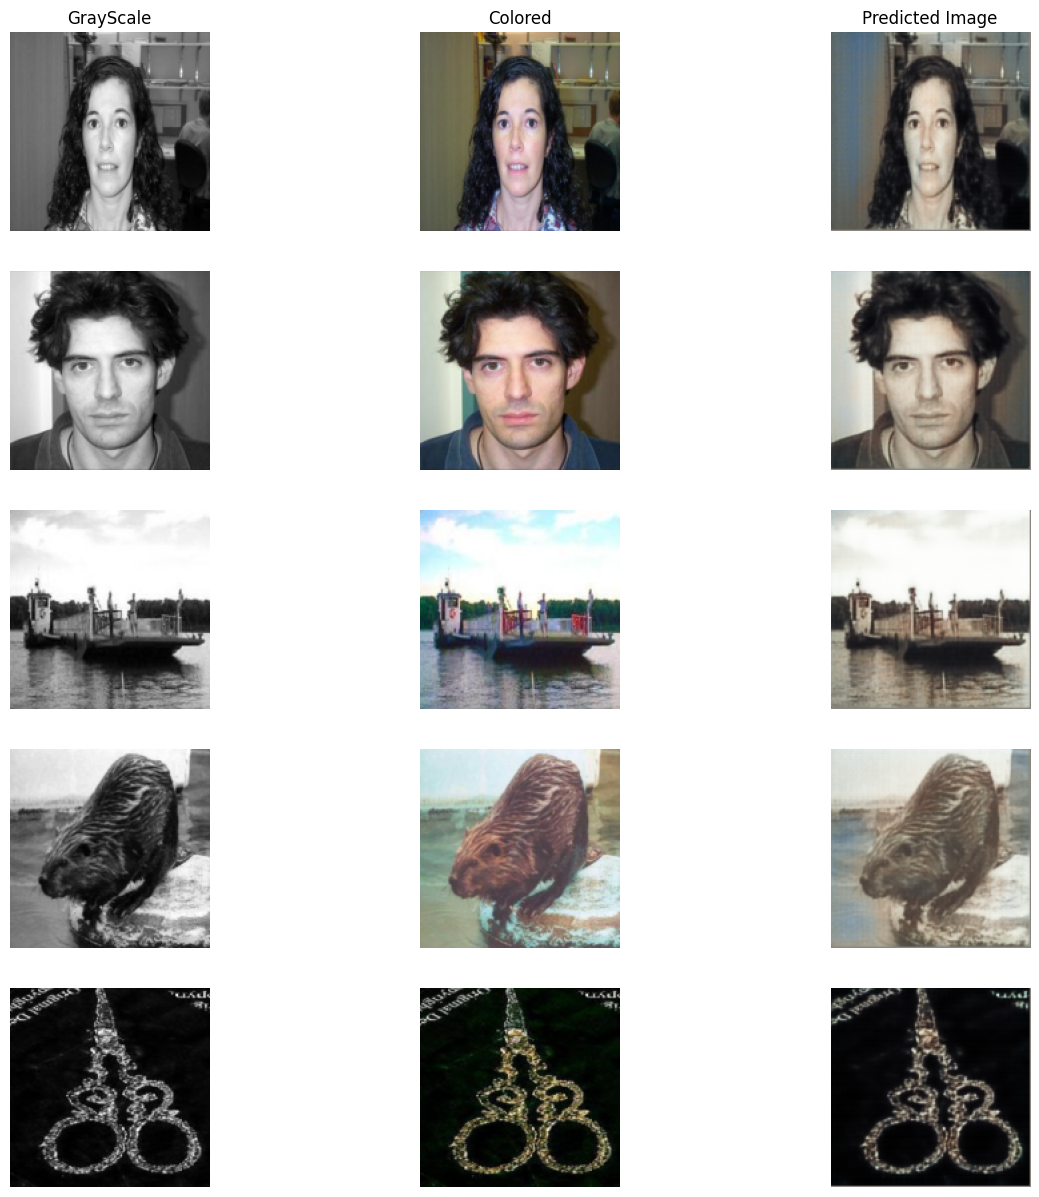

In [114]:
# visualize some prediction
def show_prediction(gray, color, pred=None):
    fig, ax = plt.subplots(5, 3, figsize=(15, 15))
    ax[0, 0].set_title('GrayScale')
    ax[0, 1].set_title('Colored')
    ax[0, 2].set_title('Predicted Image')
    for i in range(5):
        ax[i, 0].axis('off')
        ax[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        
        ax[i, 1].axis('off')
        ax[i, 1].imshow(color[i].permute(1, 2, 0))
        
        ax[i, 2].axis('off')
        
        # Check if predictions are provided
        if pred is not None:
            ax[i, 2].imshow(pred[i].permute(1, 2, 0))
    
    plt.show()

model.eval()
(gray, color), _ = next(iter(test_loader))
pred = model(gray.to(device)).detach().cpu()
show_prediction(gray, color, pred)
